In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob

path = "outputs/"
algo_names = ["1nn", "cart", "mlp", "nb", "svm", "random_forest"]
def load_results_from_term(term):
    results_data = {}
    for algo_name in algo_names:
        path_full = glob.glob(path + "full_" + term + "_" + algo_name + "*")[0]
        path_reduced = glob.glob(path + "reduced_" + term + "_" + algo_name + "*")[0]
        print(path_full)
        print(path_reduced)
        results_data[algo_name] = {
            "full": json.load(open(path_full)),
            "reduced": json.load(open(path_reduced))
        }
    
    return results_data



arit = load_results_from_term("arit")
print("-----------------------")
esc = load_results_from_term("esc")
print("---------------------------")
leit = load_results_from_term("leit")

outputs\full_arit_1nn_results.json
outputs\reduced_arit_1nn_results.json
outputs\full_arit_cart_results.json
outputs\reduced_arit_cart_results.json
outputs\full_arit_mlp_results.json
outputs\reduced_arit_mlp_results.json
outputs\full_arit_nb_results.json
outputs\reduced_arit_nb_results.json
outputs\full_arit_svm_results.json
outputs\reduced_arit_svm_results.json
outputs\full_arit_random_forest_results.json
outputs\reduced_arit_random_forest_results.json
-----------------------
outputs\full_esc_1nn_results.json
outputs\reduced_esc_1nn_results.json
outputs\full_esc_cart_results.json
outputs\reduced_esc_cart_results.json
outputs\full_esc_mlp_results.json
outputs\reduced_esc_mlp_results.json
outputs\full_esc_nb_results.json
outputs\reduced_esc_nb_results.json
outputs\full_esc_svm_results.json
outputs\reduced_esc_svm_results.json
outputs\full_esc_random_forest_results.json
outputs\reduced_esc_random_forest_results.json
---------------------------
outputs\full_leit_1nn_results.json
outputs\r

In [312]:
import pandas as pd
def get_mean_class_metric(result, score_name, label, metric):
    metrics = []
    counter = 0
    for key in result:
        if key.startswith('i'):
            x = result[key][score_name][label][metric]
            metrics.append(x)
            counter+=1
    
    return sum(metrics) / counter

def get_metric_per_classes(database, metric: str, valid_base = False):
    score_name = ""
    if valid_base:
        score_name = "valid_scores"
    else:
        score_name = "scores"
    
    full_superior_list = []
    full_inferior_list = []
    full_avg_list = []
    reduced_superior_list = []
    reduced_inferior_list = []
    reducued_avg_list = []
    columns = []
    for algo_name in algo_names:
        full_superior = get_mean_class_metric(database[algo_name]["full"], score_name, "Superior", metric)
        full_inferior = get_mean_class_metric(database[algo_name]["full"], score_name, "Inferior", metric)
        full_avg = database[algo_name]["full"]["avg_" + score_name ][metric]
        full_superior_list.append(full_superior)
        full_inferior_list.append(full_inferior)
        full_avg_list.append(full_avg)

        reduced_superior = get_mean_class_metric(database[algo_name]["reduced"], score_name, "Superior", metric)
        reduced_inferior = get_mean_class_metric(database[algo_name]["reduced"], score_name, "Inferior", metric)
        reduced_avg = database[algo_name]["reduced"]["avg_" + score_name ][metric]
        reduced_superior_list.append(reduced_superior)
        reduced_inferior_list.append(reduced_inferior)
        reducued_avg_list.append(reduced_avg)

        columns += [algo_name, algo_name + "/Ant-IS"]


    row_superior = []
    for i in range(len(algo_names)):
        row_superior += [full_superior_list[i], reduced_superior_list[i]]

        
    row_inferior = []
    for i in range(len(algo_names)):
        row_inferior += [full_inferior_list[i], reduced_inferior_list[i]]
        
    row_avg = []
    for i in range(len(algo_names)):
        row_avg += [full_avg_list[i], reducued_avg_list[i]]

    rows = np.zeros((3,12))
    rows[0] = row_superior
    rows[1] = row_inferior
    rows[2] = row_avg

    return pd.DataFrame(rows, columns=columns, index=["Superior", "Inferior", "Média"])

metric_names = ["precision","recall","f1-score","support"]
get_metric_per_classes(esc, "f1-score", valid_base=True)

,1nn,1nn/Ant-IS,cart,cart/Ant-IS,mlp,mlp/Ant-IS,nb,nb/Ant-IS,svm,svm/Ant-IS,random_forest,random_forest/Ant-IS
Superior,0.001667,0.066023,0.187164,0.181078,0.079991,0.038835,0.186670,0.188755,0.000000,0.000000,0.000000,0.042108
Inferior,0.836789,0.835837,0.780842,0.718242,0.824921,0.836025,0.700525,0.701241,0.873239,0.873239,0.867928,0.861328
Média,0.419228,0.450930,0.484003,0.449660,0.452456,0.437430,0.443598,0.444998,0.436620,0.436620,0.433964,0.451718


[85.8658, 78.8961, 79.0043, 75.3247, 73.5281, 85.7792]
[90.474, 90.0974, 85.1255, 70.0693, 73.0736, 91.8918]
[56.5, 44.0, 53.5, 53.0, 72.5, 56.5]
[51.475, 46.625, 51.3, 53.175, 72.5, 52.1]


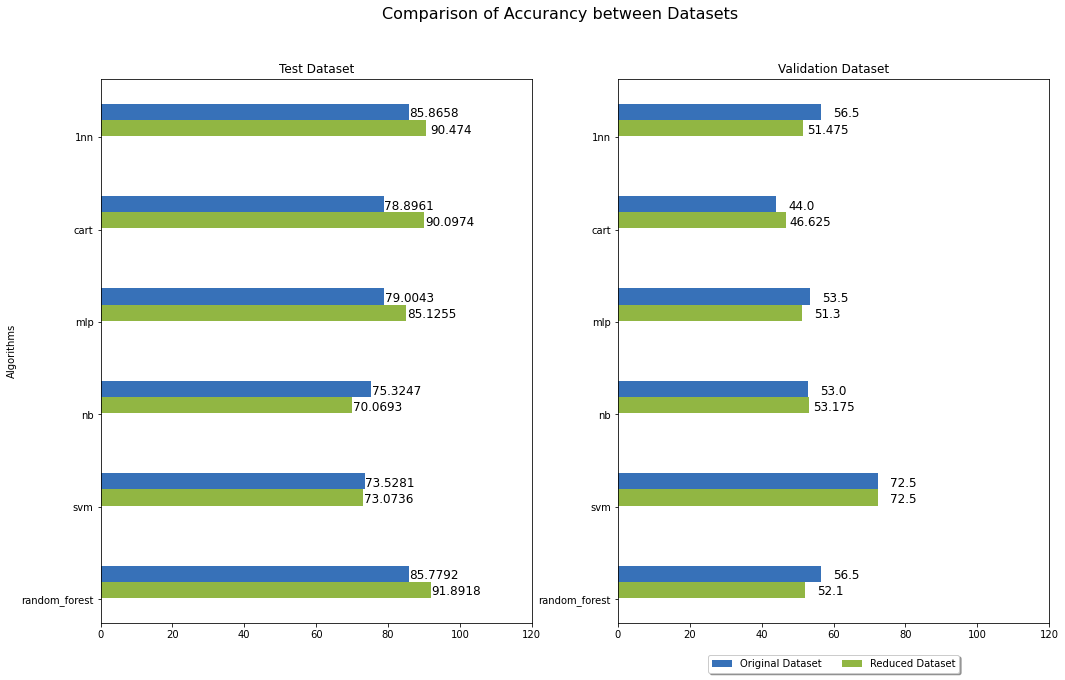

In [46]:
def get_accuracy_per_test(test_result: dict, score_name: str):
    results = []
    counter = 0
    for key in test_result.keys():
        if key.startswith('i'):
            result = test_result[key][score_name]["accuracy"]
            results.append(result)
            counter+=1

    return sum(results) / counter

def autolabel(ax, rects):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ypos = rect.get_y() + height/2
        ax.text(width + 7.0, ypos - 0.11, width, ha='center', va='bottom', rotation=0, fontsize=12) 

# acuracia base de treino
full_accuracy_train = [round(get_accuracy_per_test(arit[algo_name]["full"], "scores")*100, 4) for algo_name in algo_names]
reduced_accuracy_train = [round(get_accuracy_per_test(arit[algo_name]["reduced"], "scores")*100, 4) for algo_name in algo_names]
print(full_accuracy_train)
print(reduced_accuracy_train)


# acuracias basse de validacao
full_accuracy_valid = [round(get_accuracy_per_test(arit[algo_name]["full"], "valid_scores")*100, 4) for algo_name in algo_names]
reduced_accuracy_valid = [round(get_accuracy_per_test(arit[algo_name]["reduced"], "valid_scores")*100, 4)for algo_name in algo_names]
print(full_accuracy_valid)
print(reduced_accuracy_valid)



#Valores dos agrupamentos
Borro_precision = [49.3, 29.5, 51.5, 89.1, 75.6, 28.3, 53.9]
Leijoto_precision = [62.1, 73.5, 62.1, 78.6, 75.5, 76.7, 71.4]
Santos_precision  = [69.7, 65.3, 96.2, 100.0, 69.8, 86.3, 78.4]
Metodologia_precision  = [65.0, 73.6, 80.0, 87.0,  74.5, 83.9, 77.3]

#Valores dos agrupamentos
Borro_recall = [38.5, 24.0, 42.0, 62.8, 36.0, 69.1, 45.4]
Leijoto_recall = [72.5, 65.8, 60.0, 61.1, 70.2, 75.8, 67.6]
Santos_recall = [84.6, 60.3, 75.4, 62.5, 66.1, 85.2, 72.4]
Metodologia_recall = [79.7, 68.0, 50.0, 64.5, 69.1, 87.0, 69.7]

#Valores dos agrupamentos
Borro_fmeasure = [43.2, 26.5, 46.3, 73.7, 48.8, 40.1, 46.4]
Leijoto_fmeasure = [66.9, 69.4, 61.0, 68.8, 72.7, 76.3, 69.2]
Santos_fmeasure = [76.4, 62.7, 82.1, 71.4, 67.9, 85.7, 74.4]
Metodologia_fmeasure = [72.0, 71.1, 61.5, 74.1, 71.7, 85.5, 72.7]

#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 2

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
# r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_accuracy_train, barWidth, color='#3771B8', label='Original Dataset')
label2 = ax0.barh(r2, reduced_accuracy_train, barWidth, color='#91B643', label='Reduced Dataset')
# label3 = ax0.barh(r3, Santos_precision, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax0.barh(r4, Metodologia_precision, barWidth, color='#3771B8', label='Metodologia Proposta')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
# ax0.set_yticklabels(['Tra.', 'Oxi.', 'Lia.', 'Lig.', 'Iso.', 'Hid.', 'Ave.'])
ax0.set_yticklabels(algo_names)
ax0.set_title('Test Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
# autolabel(ax0, label3)
# autolabel(ax0, label4)


# Criando as barras
label1 = ax1.barh(r1, full_accuracy_valid, barWidth, color='#3771B8', label='Original Dataset')
label2 = ax1.barh(r2, reduced_accuracy_valid, barWidth, color='#91B643', label='Reduced Dataset')
# label3 = ax1.barh(r3, Santos_recall, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax1.barh(r4, Metodologia_recall, barWidth, color='#3771B8', label='Metodologia Proposta')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Validation Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
# autolabel(ax1, label3)
# autolabel(ax1, label4)


# Criando as barras
# label1 = ax2.barh(r1, Borro_fmeasure, barWidth, color='#704F97', label='Borro et al (2006)')
# label2 = ax2.barh(r2, Leijoto_fmeasure, barWidth, color='#91B643', label='Leijôto (2014)')
# label3 = ax2.barh(r3, Santos_fmeasure, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax2.barh(r4, Metodologia_fmeasure, barWidth, color='#3771B8', label='Metodologia Proposta')

# ax2.set_xticks(np.arange(0, 140, 20))
# ax2.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
# ax2.set_yticklabels(['Tra.', 'Oxi.', 'Lia.', 'Lig.', 'Iso.', 'Hid.', 'Ave.'])
# ax2.set_title('F-Measure')

# autolabel(ax2, label1)
# autolabel(ax2, label2)
# autolabel(ax2, label3)
# autolabel(ax2, label4) 

plt.suptitle('Comparison of Accurancy between Datasets', fontsize=16)
plt.show()

In [47]:
metric = "accuracy"


valid_precison_df = get_mean_class_metric()

# acuracia base de treino
full_arit = [round(arit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_esc = [round(esc[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_leit = [round(leit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]

reduced_arit = [round(arit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_esc = [round(esc[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_leit = [round(leit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]



#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 3

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax0.barh(r2, full_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax0.barh(r3, full_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax0.set_yticklabels(algo_names)
ax0.set_title('Original Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
autolabel(ax0, label3)


# Criando as barras
label1 = ax1.barh(r1, reduced_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax1.barh(r2, reduced_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax1.barh(r3, reduced_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Reduced Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
autolabel(ax1, label3)


plt.suptitle(f'Comparison of {metric}', fontsize=16)
plt.show()

TypeError: get_mean_class_metric() missing 4 required positional arguments: 'result', 'score_name', 'label', and 'metric'


---===Reduction Rates===---
Mean: 0.4826244343891403
Median: 0.4841628959276018
Min: 0.39819004524886875
Max: 0.5701357466063348

---===Class analsys===---


<AxesSubplot:xlabel='instance'>

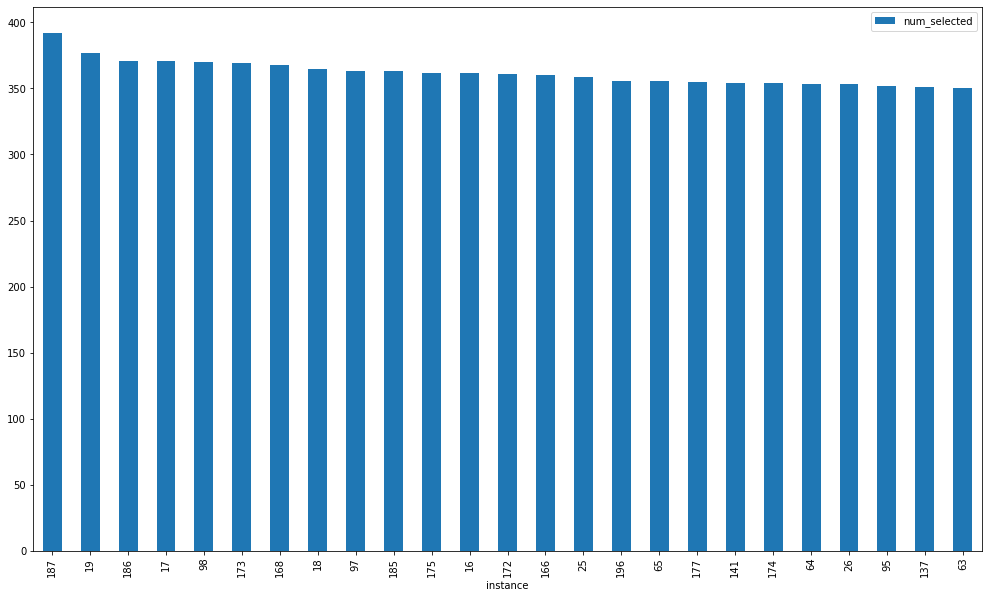

In [ ]:
def get_reduction_rate_and_selected_instance_freq(database, num_instances):
    results = []
    for algo_name in algo_names:
        results.append(database[algo_name]["reduced"])

    counter_list = []
    reduction_ratios = []
    for result in results:
        for key in result:
            if key.startswith('i'):
                selected_instances_in_cv = result[key]["selected_indices"]
                for selected_instances in selected_instances_in_cv:
                    reduction_ratios.append(len(selected_instances) / num_instances)
                    counter_array = np.zeros(num_instances)
                    counter_array[selected_instances] += 1
                    counter_list.append(counter_array)


    print()
    print("---===Reduction Rates===---")
    print(f"Mean: {np.mean(reduction_ratios)}")
    print(f"Median: {np.median(reduction_ratios)}")
    print(f"Min: {np.min(reduction_ratios)}")
    print(f"Max: {np.max(reduction_ratios)}")
    print()


    counter_list.append(np.zeros(num_instances))
    counter_list = np.array(counter_list)
    counter_row = np.zeros(num_instances)
    for i in range(num_instances):
        counter_row[i] = np.sum(counter_list[:, i])

    counter_list[-1] = counter_row


    counter_row_per_instance = \
        np.concatenate((np.arange(num_instances).reshape(-1, 1), counter_row.reshape(-1, 1)), axis=1)

    # sorted_counter_row = \
        # counter_row_per_instance[counter_row_per_instance[:, 1].argsort()][::-1]

    instances_df = pd.DataFrame(counter_list, columns=["i" + str(i) for i in range(num_instances)])
    instances_df = instances_df.astype("int32")
    sorted_counter_df = pd.DataFrame(counter_row_per_instance, columns=["instance", "num_selected"])
    sorted_counter_df = sorted_counter_df.astype('int32')
    return sorted_counter_df.sort_values("num_selected", ascending=False)
num_instance_arit = 221
num_instance_esc = 223
num_instance_leit = 191
df_counter = get_reduction_rate_and_selected_instance_freq(arit, num_instance_arit)
print("---===Class analsys===---")
df_counter.head(25).plot.bar(x="instance", y="num_selected")

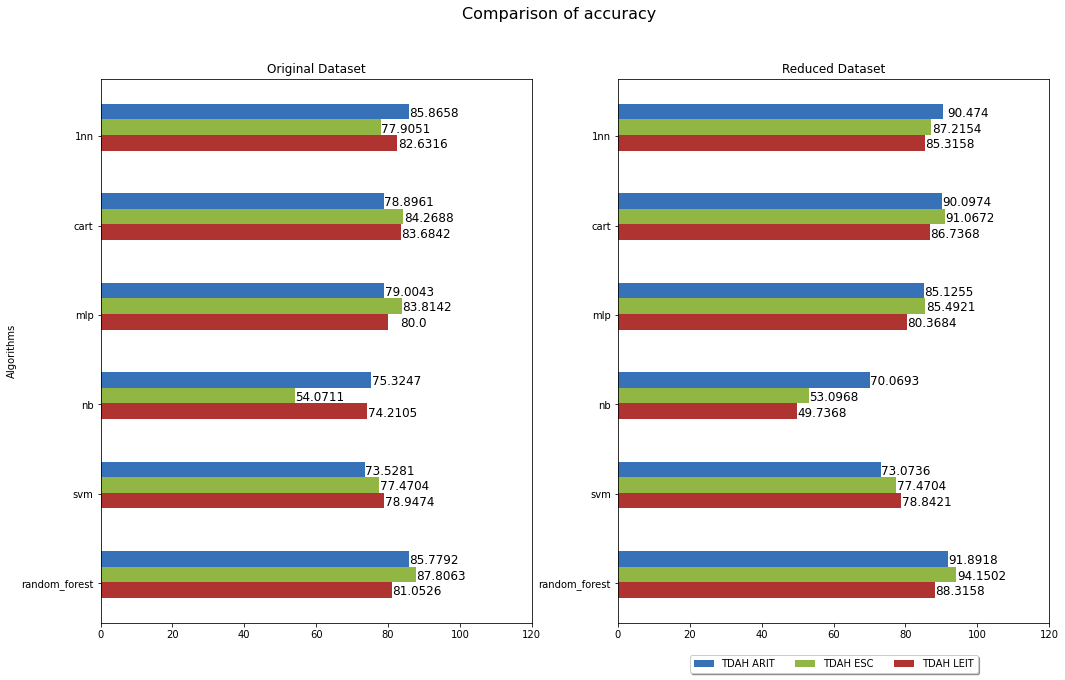

In [51]:
metric = "accuracy"

# acuracia base de treino
full_arit = [round(arit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_esc = [round(esc[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_leit = [round(leit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]

reduced_arit = [round(arit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_esc = [round(esc[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_leit = [round(leit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]



#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 3

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax0.barh(r2, full_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax0.barh(r3, full_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax0.set_yticklabels(algo_names)
ax0.set_title('Original Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
autolabel(ax0, label3)


# Criando as barras
label1 = ax1.barh(r1, reduced_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax1.barh(r2, reduced_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax1.barh(r3, reduced_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Reduced Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
autolabel(ax1, label3)


plt.suptitle(f'Comparison of {metric}', fontsize=16)
plt.show()

In [77]:
from typing import *
arit_valid_precision_df = get_metric_per_classes(arit, "precision")
arit_test_precision_df = get_metric_per_classes(arit, "precision", valid_base=True)
arit_valid_recall_df = get_metric_per_classes(arit, "recall")
arit_test_recall_df = get_metric_per_classes(arit, "recall", valid_base=True)
arit_valid_fmeasure_df = get_metric_per_classes(arit, "f1-score")
arit_test_fmeasure_df = get_metric_per_classes(arit, "f1-score", valid_base=True)

esc_valid_precision_df = get_metric_per_classes(esc, "precision")
esc_test_precision_df = get_metric_per_classes(esc, "precision", valid_base=True)
esc_valid_recall_df = get_metric_per_classes(esc, "recall")
esc_test_recall_df = get_metric_per_classes(esc, "recall", valid_base=True)
esc_valid_fmeasure_df = get_metric_per_classes(esc, "f1-score")
esc_test_fmeasure_df = get_metric_per_classes(esc, "f1-score", valid_base=True)

leit_valid_precision_df = get_metric_per_classes(leit, "precision")
leit_test_precision_df = get_metric_per_classes(leit, "precision", valid_base=True)
leit_valid_recall_df = get_metric_per_classes(leit, "recall")
leit_test_recall_df = get_metric_per_classes(leit, "recall", valid_base=True)
leit_valid_fmeasure_df = get_metric_per_classes(leit, "f1-score")
leit_test_fmeasure_df = get_metric_per_classes(leit, "f1-score", valid_base=True)

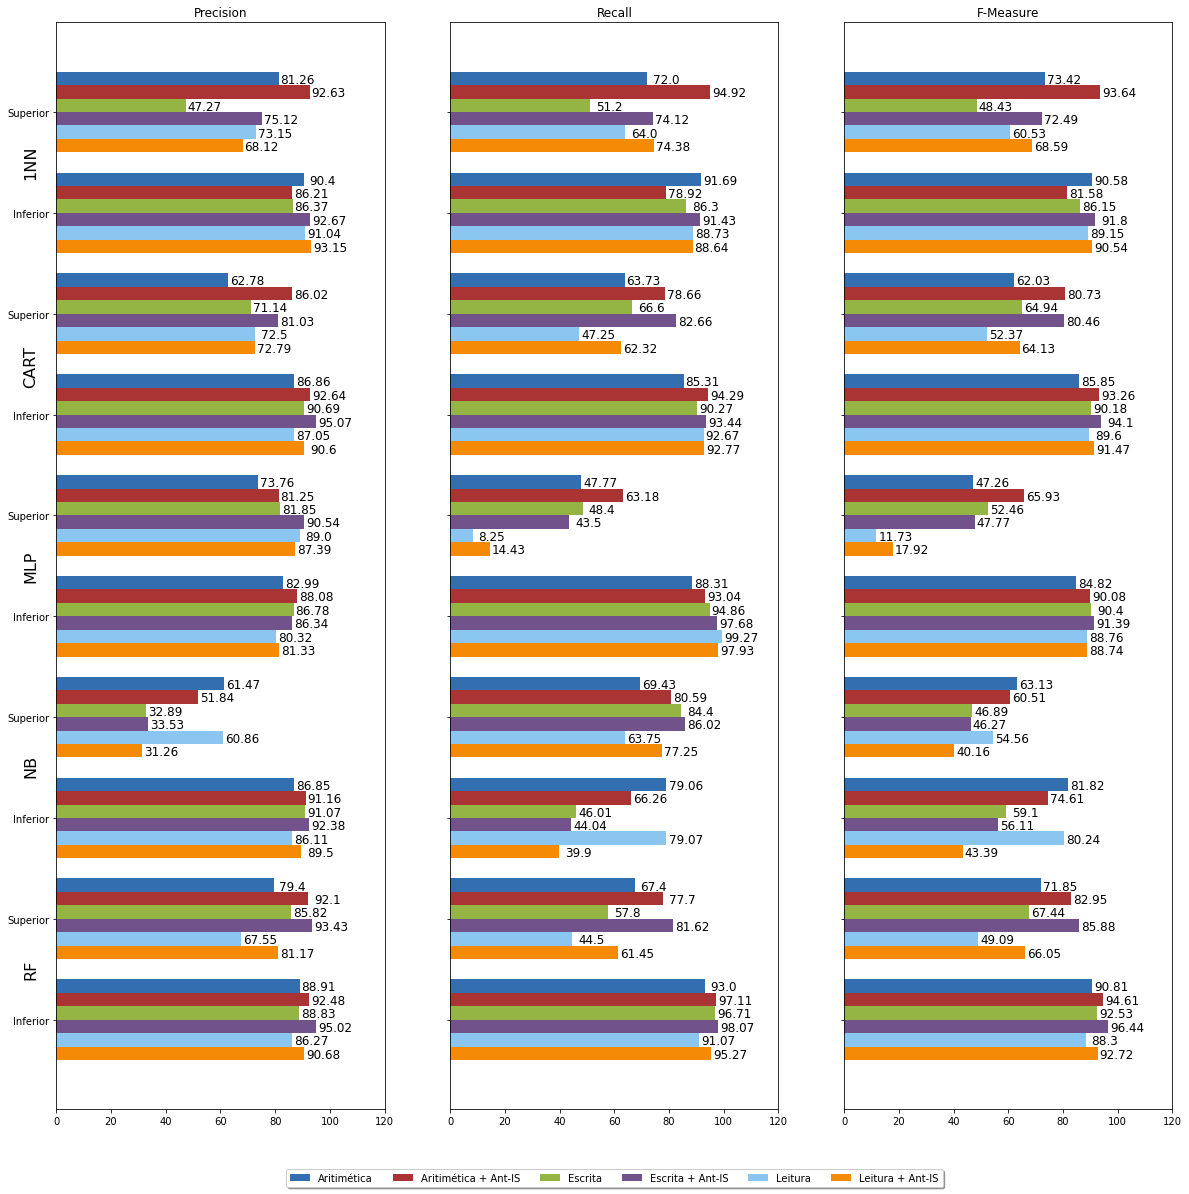

In [311]:

def get_bars_per_dfs(df_arit, df_esc, df_leit):
    return ([
        round(df_arit["1nn"].loc["Superior"]*100, 2),
        round(df_arit["1nn"].loc["Inferior"]*100, 2),
        round(df_arit["cart"].loc["Superior"]*100, 2),
        round(df_arit["cart"].loc["Inferior"]*100, 2),
        round(df_arit["mlp"].loc["Superior"]*100, 2),
        round(df_arit["mlp"].loc["Inferior"]*100, 2),
        round(df_arit["nb"].loc["Superior"]*100, 2),
        round(df_arit["nb"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest"].loc["Superior"]*100, 2),
        round(df_arit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_arit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn"].loc["Superior"]*100, 2),
        round(df_esc["1nn"].loc["Inferior"]*100, 2),
        round(df_esc["cart"].loc["Superior"]*100, 2),
        round(df_esc["cart"].loc["Inferior"]*100, 2),
        round(df_esc["mlp"].loc["Superior"]*100, 2),
        round(df_esc["mlp"].loc["Inferior"]*100, 2),
        round(df_esc["nb"].loc["Superior"]*100, 2),
        round(df_esc["nb"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest"].loc["Superior"]*100, 2),
        round(df_esc["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],
        [
        round(df_leit["1nn"].loc["Superior"]*100, 2),
        round(df_leit["1nn"].loc["Inferior"]*100, 2),
        round(df_leit["cart"].loc["Superior"]*100, 2),
        round(df_leit["cart"].loc["Inferior"]*100, 2),
        round(df_leit["mlp"].loc["Superior"]*100, 2),
        round(df_leit["mlp"].loc["Inferior"]*100, 2),
        round(df_leit["nb"].loc["Superior"]*100, 2),
        round(df_leit["nb"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest"].loc["Superior"]*100, 2),
        round(df_leit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_leit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ])


algo_labels = ['1NN', 'CART', 'MLP', 'NB', 'RF']
bars_labels = ["Aritimética", "Aritimética + Ant-IS", "Escrita",
               "Escrita + Ant-IS", "Leitura", "Leitura + Ant-IS"]

full_arit_precision,  reduced_arit_precision, full_esc_precision, reduced_esc_precision, full_leit_precision, reduced_leit_precision = get_bars_per_dfs(
    arit_valid_precision_df,
    esc_valid_precision_df,
    leit_valid_precision_df)

number_columns = len(full_arit_precision)
number_groups = 6
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
# Definindo o numero de colunas e o numero de agrupamentos


# Definindo a largura das barras
barWidth = 0.2

# Espaçamento entre barras
espacamentoEntreBarras = 0.00

# espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.5

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'small'

def autolabels(ax, labels):
    for label in labels:
        autolabel(ax, label)


def get_bars_positions(num_groups, num_columns, ):
    bars = []
    for i in range(num_groups):
        if i == 0:
            bars.append([(x * espacamentoEntreGrupos + espacamentoEntreBarras)
                        * -1 for x in range(num_columns)])
            continue

        bars.append([x - barWidth - espacamentoEntreBarras for x in bars[-1]])

    return tuple(bars)


def get_labels(ax, data_per_bar, groups, colors, bar_labels):
    labels = []

    for i in range(len(groups)):
        label = ax.barh(groups[i], data_per_bar[i], barWidth,
                        color=colors[i], label=bar_labels[i])
        labels.append(label)

    return tuple(labels)


groups = get_bars_positions(number_groups, number_columns)
labels_precision = get_labels(ax0, [
    full_arit_precision,
    reduced_arit_precision,
    full_esc_precision,
    reduced_esc_precision,
    full_leit_precision,
    reduced_leit_precision
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)

ax0.set_xticks(np.arange(0, 140, 20))
yticks = [r - barWidth - espacamentoEntreBarras - 0.3 for r in groups[0]]
ax0.set_yticks(yticks)


ax0.set_yticklabels(['Superior', 'Inferior', 'Superior', 'Inferior', 'Superior',
                    'Inferior', 'Superior',  'Inferior', 'Superior', 'Inferior'])


y = yticks[0] + ((yticks[0] + yticks[1]) / 2) + 0.3
ax0.text(-12, y, algo_labels[0], rotation='vertical', fontsize=16)

y = yticks[1] + ((yticks[1] + yticks[2]) / 2) + 0.2
ax0.text(-12, y, algo_labels[1], rotation='vertical', fontsize=16)

y = yticks[2] + ((yticks[2] + yticks[3]) / 2) + 0.3
ax0.text(-12, y, algo_labels[2], rotation='vertical', fontsize=16)

y = yticks[3] + ((yticks[3] + yticks[4]) / 2) + 0.4
ax0.text(-12, y, algo_labels[3], rotation='vertical', fontsize=16)

y = yticks[4] + ((yticks[4] + yticks[5]) / 2) + 0.4
ax0.text(-12, y, algo_labels[4], rotation='vertical', fontsize=16)

ax0.set_title('Precision')
autolabels(ax0, labels_precision)


ax1.set_title('Recall')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_valid_recall_df,
    esc_valid_recall_df,
    leit_valid_recall_df)

groups = get_bars_positions(number_groups, number_columns)
labels_recall = get_labels(ax1, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax1, labels_recall)
ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks(yticks)
ax1.set_yticklabels([])


ax2.set_title('F-Measure')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_valid_fmeasure_df,
    esc_valid_fmeasure_df,
    leit_valid_fmeasure_df
)

groups = get_bars_positions(number_groups, number_columns)
labels_fmesure = get_labels(ax2, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax2, labels_fmesure)
ax2.set_xticks(np.arange(0, 140, 20))
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)

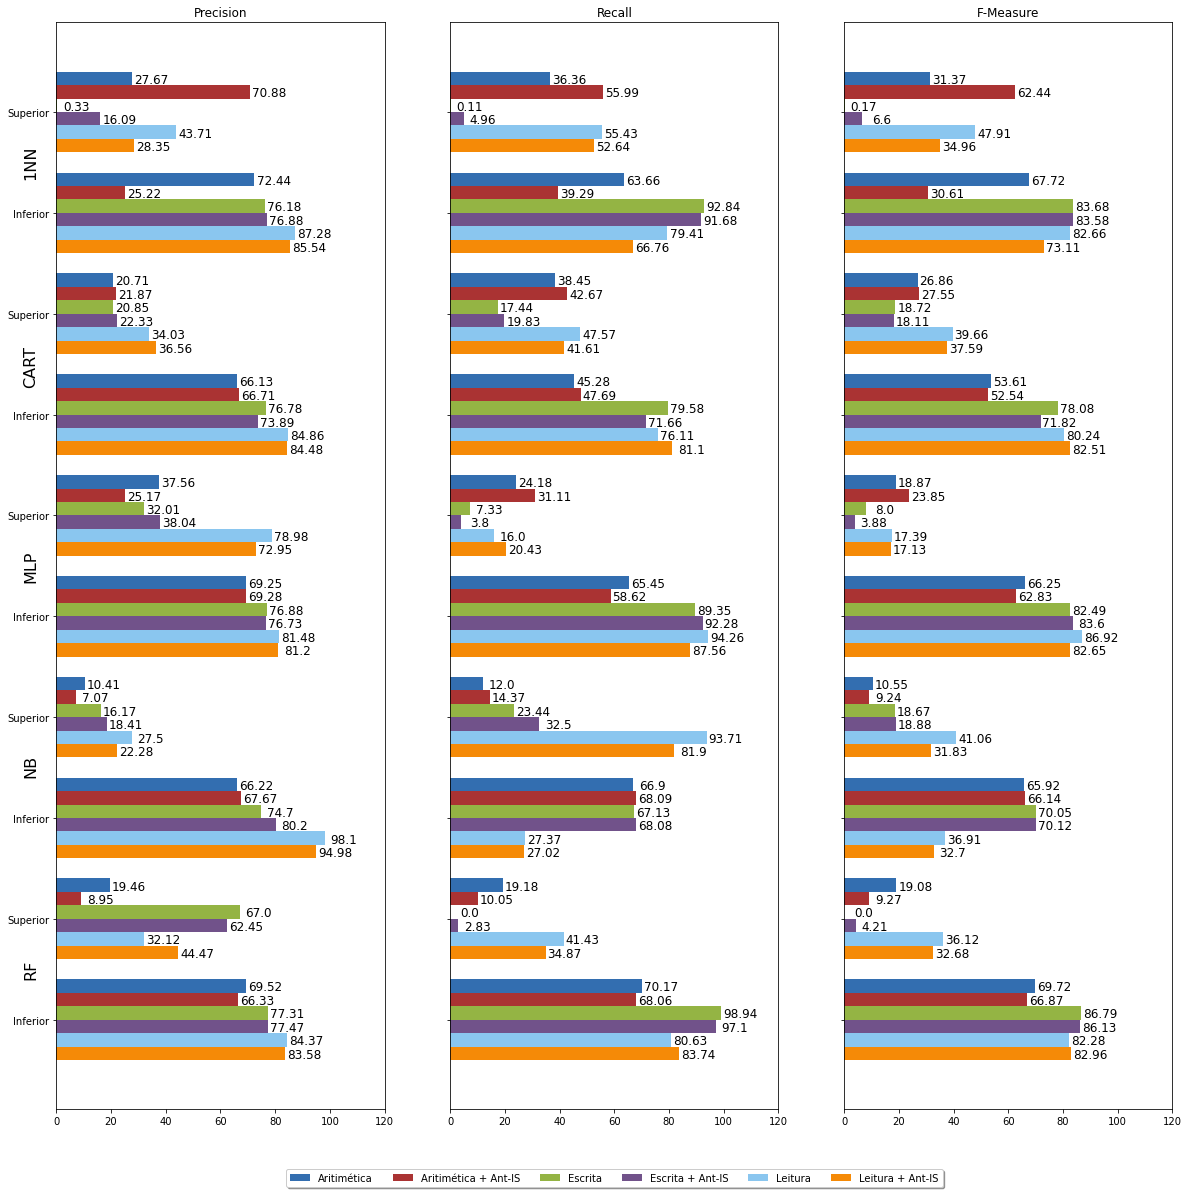

In [310]:
def get_bars_per_dfs(df_arit, df_esc, df_leit):
    return ([
        round(df_arit["1nn"].loc["Superior"]*100, 2),
        round(df_arit["1nn"].loc["Inferior"]*100, 2),
        round(df_arit["cart"].loc["Superior"]*100, 2),
        round(df_arit["cart"].loc["Inferior"]*100, 2),
        round(df_arit["mlp"].loc["Superior"]*100, 2),
        round(df_arit["mlp"].loc["Inferior"]*100, 2),
        round(df_arit["nb"].loc["Superior"]*100, 2),
        round(df_arit["nb"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest"].loc["Superior"]*100, 2),
        round(df_arit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_arit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn"].loc["Superior"]*100, 2),
        round(df_esc["1nn"].loc["Inferior"]*100, 2),
        round(df_esc["cart"].loc["Superior"]*100, 2),
        round(df_esc["cart"].loc["Inferior"]*100, 2),
        round(df_esc["mlp"].loc["Superior"]*100, 2),
        round(df_esc["mlp"].loc["Inferior"]*100, 2),
        round(df_esc["nb"].loc["Superior"]*100, 2),
        round(df_esc["nb"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest"].loc["Superior"]*100, 2),
        round(df_esc["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],
        [
        round(df_leit["1nn"].loc["Superior"]*100, 2),
        round(df_leit["1nn"].loc["Inferior"]*100, 2),
        round(df_leit["cart"].loc["Superior"]*100, 2),
        round(df_leit["cart"].loc["Inferior"]*100, 2),
        round(df_leit["mlp"].loc["Superior"]*100, 2),
        round(df_leit["mlp"].loc["Inferior"]*100, 2),
        round(df_leit["nb"].loc["Superior"]*100, 2),
        round(df_leit["nb"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest"].loc["Superior"]*100, 2),
        round(df_leit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_leit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["nb/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["nb/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ])


algo_labels = ['1NN', 'CART', 'MLP', 'NB', 'RF']
bars_labels = ["Aritimética", "Aritimética + Ant-IS", "Escrita",
               "Escrita + Ant-IS", "Leitura", "Leitura + Ant-IS"]

full_arit_precision,  reduced_arit_precision, full_esc_precision, reduced_esc_precision, full_leit_precision, reduced_leit_precision = get_bars_per_dfs(
    arit_test_precision_df,
    esc_test_precision_df,
    leit_test_precision_df)

number_columns = len(full_arit_precision)
number_groups = 6
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
# Definindo o numero de colunas e o numero de agrupamentos


# Definindo a largura das barras
barWidth = 0.2

# Espaçamento entre barras
espacamentoEntreBarras = 0.00

# espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.5

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'small'

def autolabels(ax, labels):
    for label in labels:
        autolabel(ax, label)


def get_bars_positions(num_groups, num_columns, ):
    bars = []
    for i in range(num_groups):
        if i == 0:
            bars.append([(x * espacamentoEntreGrupos + espacamentoEntreBarras)
                        * -1 for x in range(num_columns)])
            continue

        bars.append([x - barWidth - espacamentoEntreBarras for x in bars[-1]])

    return tuple(bars)


def get_labels(ax, data_per_bar, groups, colors, bar_labels):
    labels = []

    for i in range(len(groups)):
        label = ax.barh(groups[i], data_per_bar[i], barWidth,
                        color=colors[i], label=bar_labels[i])
        labels.append(label)

    return tuple(labels)


groups = get_bars_positions(number_groups, number_columns)
labels_precision = get_labels(ax0, [
    full_arit_precision,
    reduced_arit_precision,
    full_esc_precision,
    reduced_esc_precision,
    full_leit_precision,
    reduced_leit_precision
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)

ax0.set_xticks(np.arange(0, 140, 20))
yticks = [r - barWidth - espacamentoEntreBarras - 0.3 for r in groups[0]]
ax0.set_yticks(yticks)


ax0.set_yticklabels(['Superior', 'Inferior', 'Superior', 'Inferior', 'Superior',
                    'Inferior', 'Superior',  'Inferior', 'Superior', 'Inferior'])


y = yticks[0] + ((yticks[0] + yticks[1]) / 2) + 0.3
ax0.text(-12, y, algo_labels[0], rotation='vertical', fontsize=16)

y = yticks[1] + ((yticks[1] + yticks[2]) / 2) + 0.2
ax0.text(-12, y, algo_labels[1], rotation='vertical', fontsize=16)

y = yticks[2] + ((yticks[2] + yticks[3]) / 2) + 0.3
ax0.text(-12, y, algo_labels[2], rotation='vertical', fontsize=16)

y = yticks[3] + ((yticks[3] + yticks[4]) / 2) + 0.4
ax0.text(-12, y, algo_labels[3], rotation='vertical', fontsize=16)

y = yticks[4] + ((yticks[4] + yticks[5]) / 2) + 0.4
ax0.text(-12, y, algo_labels[4], rotation='vertical', fontsize=16)

ax0.set_title('Precision')
autolabels(ax0, labels_precision)


ax1.set_title('Recall')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_test_recall_df,
    esc_test_recall_df,
    leit_test_recall_df)

groups = get_bars_positions(number_groups, number_columns)
labels_recall = get_labels(ax1, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax1, labels_recall)
ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks(yticks)
ax1.set_yticklabels([])


ax2.set_title('F-Measure')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_test_fmeasure_df,
    esc_test_fmeasure_df,
    leit_test_fmeasure_df
)

groups = get_bars_positions(number_groups, number_columns)
labels_fmesure = get_labels(ax2, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax2, labels_fmesure)
ax2.set_xticks(np.arange(0, 140, 20))
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)